# Capstone Project - The Battle of the Neighborhoods¶

## Introduction

This project's main objective is first to find the safest borough in new york city (NYC), using a kaggle dataset that reveals the total number of crimes. Then, selecting the safest borough, explore its neighborhoods in order to find the most common venues in each neighborhood. The final objective is to use k-mean clustering to group neighborhoods.

Since New York City is a very desired place for migrants, this project aims to locate the safest neighborhoods within NYC, in order to facilitate the search work by people who want to move.

## Data

In order to solve this problem, it will be considered two types of data:

1. The first one corresponds a dataset from kaggle that contains the total number of crimes commited in each of the borough in 2014 and 2015.
2. The second one has to do with the most common venues in each of the neighborhood in the safest borough of NYC.

   - To do this, in a first part (Let's call Part A), it will be used a dataset from kaggle showing the New York Crimes from 2014 to 2015: https://www.kaggle.com/adamschroeder/crimes-new-york-city. 

   - Next, in Part B, using a wikipedia page, it will be scrapped additional information of the different boroughs in NYC, using Breautifulsoup library: https://en.wikipedia.org/wiki/Boroughs_of_New_York_City

   - Finally, in Part C, selected the saffest borough, it will be analysed the neighborhoods of this borough, using a new wikipedia page, and also generate its coordinates. Google maps API geocoding will be the tool used to find the coordinates. https://en.wikipedia.org/wiki/List_of_Staten_Island_neighborhoods


## Part A: Exploring Kaggle Dataset containing the crime date in NYC

In [2]:
import pandas as pd 
import numpy as np 

import requests # handle requests
import random # random number generation
from bs4 import BeautifulSoup # web scrapping  

import geocoder

from geopy.geocoders import Nominatim # latitude and longitude values

from IPython.display import Image 
from IPython.core.display import HTML 
    
from pandas.io.json import json_normalize

import folium # plot

print('Folium is already installed')
print('Libraries are already imported.')

Folium is already installed
Libraries are already imported.


In [3]:
# Foursquare Credentials and Version
CLIENT_ID = 'S2W4RLHIQ10GTEZ5IKEKWWAH5VSQD1WFNLNRUPFJUHCAA1GY' # your Foursquare ID
CLIENT_SECRET = '42MERQXTX2OOFRJ0MK1QTFJBWDHF2CNNTU4K10QSS1K53V5V' # your Foursquare Secret
VERSION = '20200209' 
LIMIT = 30

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: S2W4RLHIQ10GTEZ5IKEKWWAH5VSQD1WFNLNRUPFJUHCAA1GY
CLIENT_SECRET:42MERQXTX2OOFRJ0MK1QTFJBWDHF2CNNTU4K10QSS1K53V5V


In [4]:
# Read kaggle dataset
df = pd.read_csv('NYPD_Complaint_Data_Historic.csv')

C:\Users\Asus\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.shape

(1048575, 24)

In [6]:
df.head(3) # first 3 rows of the dataset

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,101109527,12/31/2015,23:45:00,NaN,NaN,12/31/2015,113,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,44.0,INSIDE,BAR/NIGHT CLUB,NaN,NaN,1007314.0,241257.0,40.828848,-73.916661,"(40.828848333, -73.916661142)"
1,153401121,12/31/2015,23:36:00,NaN,NaN,12/31/2015,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,...,103.0,OUTSIDE,NaN,NaN,NaN,1043991.0,193406.0,40.697338,-73.784557,"(40.697338138, -73.784556739)"
2,569369778,12/31/2015,23:30:00,NaN,NaN,12/31/2015,117,DANGEROUS DRUGS,503.0,"CONTROLLED SUBSTANCE,INTENT TO",...,28.0,NaN,OTHER,NaN,NaN,999463.0,231690.0,40.802607,-73.945052,"(40.802606608, -73.945051911)"


In [7]:
# Clean some columns
df = df[['CMPLNT_NUM','CMPLNT_FR_DT','OFNS_DESC','BORO_NM']]

df = df.rename(columns={"BORO_NM": "Borough", "OFNS_DESC": "crimes"})

In [8]:
# Convert to datetime
df['CMPLNT_FR_DT'] =  pd.to_datetime(df['CMPLNT_FR_DT'], format='%m/%d/%Y', errors = 'coerce')

# Get the year 
df['year'] = df['CMPLNT_FR_DT'].dt.year

In [9]:
# Drop all the rows that are not from 2015 
df.drop(df.index[df['year'] != 2015], inplace = True)

# Reset the index 
df = df.reset_index(drop=True)

In [10]:
df.shape

(468576, 5)

In [11]:
# Count the total number of crimes in each Borough of NYC
df['Borough'].value_counts()

BROOKLYN         140351
MANHATTAN        110580
BRONX            102950
QUEENS            92981
STATEN ISLAND     21714
Name: Borough, dtype: int64

In [12]:
# Count the total number of crimes per category
df['crimes'].value_counts()

PETIT LARCENY                           80205
HARRASSMENT 2                           61339
ASSAULT 3 & RELATED OFFENSES            51932
CRIMINAL MISCHIEF & RELATED OF          47586
GRAND LARCENY                           42067
DANGEROUS DRUGS                         23645
FELONY ASSAULT                          20259
OFF. AGNST PUB ORD SENSBLTY &           20141
ROBBERY                                 16913
BURGLARY                                15000
MISCELLANEOUS PENAL LAW                 13283
DANGEROUS WEAPONS                       10505
OFFENSES AGAINST PUBLIC ADMINI           9310
GRAND LARCENY OF MOTOR VEHICLE           7248
VEHICLE AND TRAFFIC LAWS                 6259
INTOXICATED & IMPAIRED DRIVING           5923
SEX CRIMES                               5030
FORGERY                                  4997
CRIMINAL TRESPASS                        4314
THEFT-FRAUD                              4221
FRAUDS                                   3267
POSSESSION OF STOLEN PROPERTY     

In [13]:
# Ttable to view the no. of crimes of each category per Borough
NYCrimes  = pd.crosstab(df['Borough'], df['crimes'])

# Sum of the crimes in each borough
NYCrimes ['Total'] = NYCrimes.sum(axis=1)
NYCrimes 

crimes,ABORTION,ADMINISTRATIVE CODE,ADMINISTRATIVE CODES,AGRICULTURE & MRKTS LAW-UNCLASSIFIED,ALCOHOLIC BEVERAGE CONTROL LAW,ANTICIPATORY OFFENSES,ARSON,ASSAULT 3 & RELATED OFFENSES,BURGLAR'S TOOLS,BURGLARY,...,RAPE,ROBBERY,SEX CRIMES,THEFT OF SERVICES,THEFT-FRAUD,UNAUTHORIZED USE OF A VEHICLE,UNDER THE INFLUENCE OF DRUGS,UNLAWFUL POSS. WEAP. ON SCHOOL,VEHICLE AND TRAFFIC LAWS,Total
Borough,,,,,,,,,,,,,,,,,,,,,
BRONX,0,212,0,29,35,1,299,13224,33,2662,...,297,4368,999,73,688,224,0,0,1201,102712
BROOKLYN,0,404,1,19,20,0,322,16019,71,5491,...,350,5686,1420,38,1187,489,0,0,1716,140085
MANHATTAN,0,112,0,16,21,0,195,9993,112,2743,...,248,3143,1474,280,1323,142,0,2,1063,110196
QUEENS,2,291,1,13,2,1,146,10507,64,3544,...,235,3260,972,44,769,542,0,0,2105,92732
STATEN ISLAND,0,34,0,6,0,0,46,2189,6,560,...,34,456,165,0,254,135,1,0,174,21678


In [14]:
# Final Shape of the dataset
NYCrimes.shape

(5, 67)

## Part B - Extra informations from the Boroughs of NYC

In [15]:
# from wikipedia page getting some information
wikipedia_link='https://en.wikipedia.org/wiki/Boroughs_of_New_York_City'
raw_wikipedia_page= requests.get(wikipedia_link).text

# using beautiful soup to parse the HTML/XML codes.
soup = BeautifulSoup(raw_wikipedia_page,'xml')
print(soup.prettify())

<?xml version="1.0" encoding="utf-8"?>
<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="UTF-8"/>
  <title>
   Boroughs of New York City - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgMonthNamesShort":["","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],"wgRequestId":"Xj9CDgpAICMAADFowKwAAACU","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"Boroughs_of_New_York_City","wgTitle":"Boroughs of New York City","wgCurRevisionId":936653680,"wgRevisionId":936653680,"wgArticleId":5155825,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCateg

In [16]:
# extracting the raw table inside that webpage
nyctable = soup.find_all('table', {'class':'wikitable sortable'})
print(nyctable)

[<table border="1" class="wikitable sortable" style="float:center; text-align:right; font-size:85%; margin:1em;">
<tbody><tr>
<th colspan="9" style="background-color:tan;"><div style="text-align:center; position:relative; white-space:nowrap;">New York City's <a class="mw-selflink selflink">five boroughs</a><div class="plainlinks hlist navbar mini" style="position:absolute; right:0; top:0; margin:0 5px;"><ul><li class="nv-view"><a href="/wiki/Template:NYC_boroughs" title="Template:NYC boroughs"><abbr title="View this template">v</abbr></a></li><li class="nv-talk"><a href="/wiki/Template_talk:NYC_boroughs" title="Template talk:NYC boroughs"><abbr title="Discuss this template">t</abbr></a></li><li class="nv-edit"><a class="external text" href="https://en.wikipedia.org/w/index.php?title=Template:NYC_boroughs&amp;action=edit"><abbr title="Edit this template">e</abbr></a></li></ul></div></div>
</th></tr>
<tr style="background:#dedebb;">
<th colspan="2" style="background: transparent">Jurisdi

In [17]:
NYC_table = pd.read_html(str(nyctable[0]), index_col=None, header=2)[0] # dataframe
NYC_table = NYC_table.iloc[0:5]
NYC_table

,Borough,County,Estimate (2017)[3],billions(US$)[4],per capita(US$),square miles,squarekm,persons / sq. mi,persons /km2
0,The Bronx,Bronx,1471160.0,42.695,29200.0,42.10,109.04,34653.0,13231.0
1,Brooklyn,Kings,2648771.0,91.559,34600.0,70.82,183.42,37137.0,14649.0
2,Manhattan,New York,1664727.0,600.244,360600.0,22.83,59.13,72033.0,27826.0
3,Queens,Queens,2358582.0,93.310,39600.0,108.53,281.09,21460.0,8354.0
4,Staten Island,Richmond,479458.0,14.514,30300.0,58.37,151.18,8112.0,3132.0


In [18]:
NYC_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 9 columns):
Borough               5 non-null object
County                5 non-null object
Estimate (2017)[3]    5 non-null float64
billions(US$)[4]      5 non-null float64
per capita(US$)       5 non-null float64
square miles          5 non-null float64
squarekm              5 non-null float64
persons / sq. mi      5 non-null float64
persons /km2          5 non-null float64
dtypes: float64(7), object(2)
memory usage: 440.0+ bytes


In [19]:
NYC_table.shape

(5, 9)

In [20]:
# Borough are the same in both data frames?
set(df.Borough) - set(NYC_table.Borough)

# It matches, however the size of letter is different

{'BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'}

In [21]:
# Index of the Boroughs that didn't match
print("The index of first borough is",NYC_table.index[NYC_table['Borough'] == 'The Bronx'].tolist())
print("The index of second borough is",NYC_table.index[NYC_table['Borough'] == 'Brooklyn'].tolist())
print("The index of third borough is",NYC_table.index[NYC_table['Borough'] == 'Manhattan'].tolist())
print("The index of fourth borough is",NYC_table.index[NYC_table['Borough'] ==  'Queens'].tolist())
print("The index of fiveth borough is",NYC_table.index[NYC_table['Borough'] == 'Staten Island'].tolist())

The index of first borough is [0]
The index of second borough is [1]
The index of third borough is [2]
The index of fourth borough is [3]
The index of fiveth borough is [4]


In [22]:
# Change the names to match the dataframe
NYC_table.iloc[0,0] = 'BRONX'
NYC_table.iloc[1,0] = 'BROOKLYN'
NYC_table.iloc[2,0] = 'MANHATTAN'
NYC_table.iloc[3,0] = 'QUEENS'
NYC_table.iloc[4,0] = 'STATEN ISLAND'

In [23]:
NYC_table.head(5)

,Borough,County,Estimate (2017)[3],billions(US$)[4],per capita(US$),square miles,squarekm,persons / sq. mi,persons /km2
0,BRONX,Bronx,1471160.0,42.695,29200.0,42.10,109.04,34653.0,13231.0
1,BROOKLYN,Kings,2648771.0,91.559,34600.0,70.82,183.42,37137.0,14649.0
2,MANHATTAN,New York,1664727.0,600.244,360600.0,22.83,59.13,72033.0,27826.0
3,QUEENS,Queens,2358582.0,93.310,39600.0,108.53,281.09,21460.0,8354.0
4,STATEN ISLAND,Richmond,479458.0,14.514,30300.0,58.37,151.18,8112.0,3132.0


In [24]:
# Are now equal?
set(df.Borough) - set(NYC_table.Borough)

# It matches!

set()

In [25]:
# combine data frames
NYC_crime = pd.merge(NYCrimes, NYC_table, on='Borough')
NYC_crime.head()

,Borough,ABORTION,ADMINISTRATIVE CODE,ADMINISTRATIVE CODES,AGRICULTURE & MRKTS LAW-UNCLASSIFIED,ALCOHOLIC BEVERAGE CONTROL LAW,ANTICIPATORY OFFENSES,ARSON,ASSAULT 3 & RELATED OFFENSES,BURGLAR'S TOOLS,...,VEHICLE AND TRAFFIC LAWS,Total,County,Estimate (2017)[3],billions(US$)[4],per capita(US$),square miles,squarekm,persons / sq. mi,persons /km2
0,BRONX,0,212,0,29,35,1,299,13224,33,...,1201,102712,Bronx,1471160.0,42.695,29200.0,42.10,109.04,34653.0,13231.0
1,BROOKLYN,0,404,1,19,20,0,322,16019,71,...,1716,140085,Kings,2648771.0,91.559,34600.0,70.82,183.42,37137.0,14649.0
2,MANHATTAN,0,112,0,16,21,0,195,9993,112,...,1063,110196,New York,1664727.0,600.244,360600.0,22.83,59.13,72033.0,27826.0
3,QUEENS,2,291,1,13,2,1,146,10507,64,...,2105,92732,Queens,2358582.0,93.310,39600.0,108.53,281.09,21460.0,8354.0
4,STATEN ISLAND,0,34,0,6,0,0,46,2189,6,...,174,21678,Richmond,479458.0,14.514,30300.0,58.37,151.18,8112.0,3132.0


In [26]:
NYC_crime.shape

(5, 76)

In [60]:
set(df.Borough) - set(NYC_crime.Borough)

set()

In [62]:
# Columns names
NYC_crime.columns.values 

array(['Borough', 'ABORTION', 'ADMINISTRATIVE CODE',
       'ADMINISTRATIVE CODES', 'AGRICULTURE & MRKTS LAW-UNCLASSIFIED',
       'ALCOHOLIC BEVERAGE CONTROL LAW', 'ANTICIPATORY OFFENSES', 'ARSON',
       'ASSAULT 3 & RELATED OFFENSES', "BURGLAR'S TOOLS", 'BURGLARY',
       'CHILD ABANDONMENT/NON SUPPORT', 'CRIMINAL MISCHIEF & RELATED OF',
       'CRIMINAL TRESPASS', 'DANGEROUS DRUGS', 'DANGEROUS WEAPONS',
       'DISORDERLY CONDUCT', 'DISRUPTION OF A RELIGIOUS SERV',
       'ENDAN WELFARE INCOMP', 'ESCAPE 3', 'FELONY ASSAULT', 'FORGERY',
       'FORTUNE TELLING', 'FRAUDS', 'FRAUDULENT ACCOSTING', 'GAMBLING',
       'GRAND LARCENY', 'GRAND LARCENY OF MOTOR VEHICLE', 'HARRASSMENT 2',
       'HOMICIDE-NEGLIGENT-VEHICLE', 'INTOXICATED & IMPAIRED DRIVING',
       'INTOXICATED/IMPAIRED DRIVING', 'JOSTLING', 'KIDNAPPING',
       'KIDNAPPING & RELATED OFFENSES', 'KIDNAPPING AND RELATED OFFENSES',
       'LOITERING', 'LOITERING/GAMBLING (CARDS, DIC',
       'MISCELLANEOUS PENAL LAW', 'MURDER 

From the exploratory analysis, it will be possible to see crime rates in NYC so that the safest borough can be identified. Then, the neighborhood of that borough will be extracted and the most common ones will be grouped.

Finally, so that people who want to move to one of the neighborhoods in NYC (the safest one), k-means clustering will be used in order to group similar neighborhoods. A cluster of 5 will be used in order to group the neighborhoods into 5 groups. This way people can select the neighborhoods of interest based on their amenities.

In [28]:
# Descriptive Analysis 
NYCrimes.describe()

crimes,ABORTION,ADMINISTRATIVE CODE,ADMINISTRATIVE CODES,AGRICULTURE & MRKTS LAW-UNCLASSIFIED,ALCOHOLIC BEVERAGE CONTROL LAW,ANTICIPATORY OFFENSES,ARSON,ASSAULT 3 & RELATED OFFENSES,BURGLAR'S TOOLS,BURGLARY,...,RAPE,ROBBERY,SEX CRIMES,THEFT OF SERVICES,THEFT-FRAUD,UNAUTHORIZED USE OF A VEHICLE,UNDER THE INFLUENCE OF DRUGS,UNLAWFUL POSS. WEAP. ON SCHOOL,VEHICLE AND TRAFFIC LAWS,Total
count,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.400000,210.60000,0.400000,16.600000,15.600000,0.400000,201.600000,10386.400000,57.200000,3000.000000,...,232.800000,3382.600000,1006.000000,87.000000,844.200000,306.400000,0.200000,0.400000,1251.800000,93480.600000
std,0.894427,145.58434,0.547723,8.443933,14.604794,0.547723,113.279742,5175.539373,40.145984,1777.280929,...,120.015416,1930.938321,524.143587,110.977475,425.778933,194.964869,0.447214,0.894427,732.002527,43854.210776
min,0.000000,34.00000,0.000000,6.000000,0.000000,0.000000,46.000000,2189.000000,6.000000,560.000000,...,34.000000,456.000000,165.000000,0.000000,254.000000,135.000000,0.000000,0.000000,174.000000,21678.000000
25%,0.000000,112.00000,0.000000,13.000000,2.000000,0.000000,146.000000,9993.000000,33.000000,2662.000000,...,235.000000,3143.000000,972.000000,38.000000,688.000000,142.000000,0.000000,0.000000,1063.000000,92732.000000
50%,0.000000,212.00000,0.000000,16.000000,20.000000,0.000000,195.000000,10507.000000,64.000000,2743.000000,...,248.000000,3260.000000,999.000000,44.000000,769.000000,224.000000,0.000000,0.000000,1201.000000,102712.000000
75%,0.000000,291.00000,1.000000,19.000000,21.000000,1.000000,299.000000,13224.000000,71.000000,3544.000000,...,297.000000,4368.000000,1420.000000,73.000000,1187.000000,489.000000,0.000000,0.000000,1716.000000,110196.000000
max,2.000000,404.00000,1.000000,29.000000,35.000000,1.000000,322.000000,16019.000000,112.000000,5491.000000,...,350.000000,5686.000000,1474.000000,280.000000,1323.000000,542.000000,1.000000,2.000000,2105.000000,140085.000000


In [39]:
pd.set_option('display.max_columns', None) # Show the whole table

In [42]:
NYCrimes.describe()

crimes,ABORTION,ADMINISTRATIVE CODE,ADMINISTRATIVE CODES,AGRICULTURE & MRKTS LAW-UNCLASSIFIED,ALCOHOLIC BEVERAGE CONTROL LAW,ANTICIPATORY OFFENSES,ARSON,ASSAULT 3 & RELATED OFFENSES,BURGLAR'S TOOLS,BURGLARY,CHILD ABANDONMENT/NON SUPPORT,CRIMINAL MISCHIEF & RELATED OF,CRIMINAL TRESPASS,DANGEROUS DRUGS,DANGEROUS WEAPONS,DISORDERLY CONDUCT,DISRUPTION OF A RELIGIOUS SERV,ENDAN WELFARE INCOMP,ESCAPE 3,FELONY ASSAULT,FORGERY,FORTUNE TELLING,FRAUDS,FRAUDULENT ACCOSTING,GAMBLING,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,HARRASSMENT 2,HOMICIDE-NEGLIGENT-VEHICLE,INTOXICATED & IMPAIRED DRIVING,INTOXICATED/IMPAIRED DRIVING,JOSTLING,KIDNAPPING,KIDNAPPING & RELATED OFFENSES,KIDNAPPING AND RELATED OFFENSES,LOITERING,"LOITERING/GAMBLING (CARDS, DIC",MISCELLANEOUS PENAL LAW,MURDER & NON-NEGL. MANSLAUGHTER,NEW YORK CITY HEALTH CODE,NYS LAWS-UNCLASSIFIED FELONY,NYS LAWS-UNCLASSIFIED VIOLATION,OFF. AGNST PUB ORD SENSBLTY &,OFFENSES AGAINST PUBLIC ADMINI,OFFENSES AGAINST PUBLIC SAFETY,OFFENSES AGAINST THE PERSON,OFFENSES INVOLVING FRAUD,OFFENSES RELATED TO CHILDREN,OTHER OFFENSES RELATED TO THEF,OTHER STATE LAWS,OTHER STATE LAWS (NON PENAL LA,OTHER STATE LAWS (NON PENAL LAW),OTHER TRAFFIC INFRACTION,PETIT LARCENY,PETIT LARCENY OF MOTOR VEHICLE,POSSESSION OF STOLEN PROPERTY,PROSTITUTION & RELATED OFFENSES,RAPE,ROBBERY,SEX CRIMES,THEFT OF SERVICES,THEFT-FRAUD,UNAUTHORIZED USE OF A VEHICLE,UNDER THE INFLUENCE OF DRUGS,UNLAWFUL POSS. WEAP. ON SCHOOL,VEHICLE AND TRAFFIC LAWS,Total
count,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.400000,210.60000,0.400000,16.600000,15.600000,0.400000,201.600000,10386.400000,57.200000,3000.000000,6.400000,9517.200000,862.800000,4729.000000,2101.00000,10.800000,1.20000,4.400000,2.800000,4051.800000,999.400000,0.200000,653.400000,34.400000,68.400000,8413.400000,1449.600000,12267.800000,0.600000,1184.600000,1.000000,7.600000,0.200000,26.800000,0.200000,0.200000,2.600000,2656.600000,67.200000,2.20000,85.200000,1.20000,4028.200000,1862.000000,14.200000,255.600000,233.800000,29.000000,301.600000,2.20000,65.200000,0.200000,0.200000,16041.000000,14.200000,400.600000,21.800000,232.800000,3382.600000,1006.000000,87.000000,844.200000,306.400000,0.200000,0.400000,1251.800000,93480.600000
std,0.894427,145.58434,0.547723,8.443933,14.604794,0.547723,113.279742,5175.539373,40.145984,1777.280929,3.974921,4124.681103,472.280319,3523.831225,1143.59805,9.418068,0.83666,2.966479,2.167948,2216.082738,590.085841,0.447214,249.634333,61.553229,68.791715,5426.162944,941.586321,5356.941497,0.894427,522.785138,1.414214,8.619745,0.447214,18.926172,0.447214,0.447214,3.714835,1793.656545,47.709538,3.34664,46.402586,0.83666,1751.135546,889.769071,7.918333,121.635932,217.604458,36.055513,163.775151,2.48998,48.535554,0.447214,0.447214,8284.128651,7.155418,224.940659,24.641429,120.015416,1930.938321,524.143587,110.977475,425.778933,194.964869,0.447214,0.894427,732.002527,43854.210776
min,0.000000,34.00000,0.000000,6.000000,0.000000,0.000000,46.000000,2189.000000,6.000000,560.000000,0.000000,2991.000000,107.000000,616.000000,309.00000,0.000000,0.00000,0.000000,1.000000,686.000000,56.000000,0.000000,275.000000,0.000000,0.000000,1219.000000,215.000000,4310.000000,0.000000,676.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,578.000000,13.000000,0.00000,31.000000,0.00000,1427.000000,627.000000,5.000000,58.000000,20.000000,0.000000,39.000000,0.00000,10.000000,0.000000,0.000000,3274.0000

In [37]:
pd.reset_option('display.max_columns', None) # Show just part of the tables

In [63]:
# inline backend allows to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') 

# latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

import matplotlib.cm as cm
import matplotlib.colors as colors

Matplotlib version:  3.0.2


In [64]:
# Column names are strings?
NYC_crime.columns = list(map(str, NYC_crime.columns))

# Column labels types
all(isinstance(column, str) for column in NYC_crime.columns)

True

In [65]:
NYC_crime.sort_values(['Total'], ascending = True, axis = 0, inplace = True )

df_5low = NYC_crime.head() 
df_5low

,Borough,ABORTION,ADMINISTRATIVE CODE,ADMINISTRATIVE CODES,AGRICULTURE & MRKTS LAW-UNCLASSIFIED,ALCOHOLIC BEVERAGE CONTROL LAW,ANTICIPATORY OFFENSES,ARSON,ASSAULT 3 & RELATED OFFENSES,BURGLAR'S TOOLS,BURGLARY,CHILD ABANDONMENT/NON SUPPORT,CRIMINAL MISCHIEF & RELATED OF,CRIMINAL TRESPASS,DANGEROUS DRUGS,DANGEROUS WEAPONS,DISORDERLY CONDUCT,DISRUPTION OF A RELIGIOUS SERV,ENDAN WELFARE INCOMP,ESCAPE 3,FELONY ASSAULT,FORGERY,FORTUNE TELLING,FRAUDS,FRAUDULENT ACCOSTING,GAMBLING,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,HARRASSMENT 2,HOMICIDE-NEGLIGENT-VEHICLE,INTOXICATED & IMPAIRED DRIVING,INTOXICATED/IMPAIRED DRIVING,JOSTLING,KIDNAPPING,KIDNAPPING & RELATED OFFENSES,KIDNAPPING AND RELATED OFFENSES,LOITERING,"LOITERING/GAMBLING (CARDS, DIC",MISCELLANEOUS PENAL LAW,MURDER & NON-NEGL. MANSLAUGHTER,NEW YORK CITY HEALTH CODE,NYS LAWS-UNCLASSIFIED FELONY,NYS LAWS-UNCLASSIFIED VIOLATION,OFF. AGNST PUB ORD SENSBLTY &,OFFENSES AGAINST PUBLIC ADMINI,OFFENSES AGAINST PUBLIC SAFETY,OFFENSES AGAINST THE PERSON,OFFENSES INVOLVING FRAUD,OFFENSES RELATED TO CHILDREN,OTHER OFFENSES RELATED TO THEF,OTHER STATE LAWS,OTHER STATE LAWS (NON PENAL LA,OTHER STATE LAWS (NON PENAL LAW),OTHER TRAFFIC INFRACTION,PETIT LARCENY,PETIT LARCENY OF MOTOR VEHICLE,POSSESSION OF STOLEN PROPERTY,PROSTITUTION & RELATED OFFENSES,RAPE,ROBBERY,SEX CRIMES,THEFT OF SERVICES,THEFT-FRAUD,UNAUTHORIZED USE OF A VEHICLE,UNDER THE INFLUENCE OF DRUGS,UNLAWFUL POSS. WEAP. ON SCHOOL,VEHICLE AND TRAFFIC LAWS,Total,County,Estimate (2017)[3],billions(US$)[4],per capita(US$),square miles,squarekm,persons / sq. mi,persons /km2
4,STATEN ISLAND,0,34,0,6,0,0,46,2189,6,560,0,2991,107,616,309,0,0,0,1,686,56,0,275,0,0,1219,215,4310,0,676,0,0,0,2,0,0,0,578,13,0,31,0,1427,627,5,58,20,0,39,0,10,0,0,3274,6,67,0,34,456,165,0,254,135,1,0,174,21678,Richmond,479458.0,14.514,30300.0,58.37,151.18,8112.0,3132.0
3,QUEENS,2,291,1,13,2,1,146,10507,64,3544,9,10470,802,1653,1868,3,2,3,2,3966,998,0,588,8,4,7815,2227,12284,0,1569,0,7,0,25,0,0,0,3492,59,1,53,1,4195,1454,8,229,145,36,320,2,23,0,0,15525,18,364,6,235,3260,972,44,769,542,0,0,2105,92732,Queens,2358582.0,93.310,39600.0,108.53,281.09,21460.0,8354.0
0,BRONX,0,212,0,29,35,1,299,13224,33,2662,9,10015,979,9119,3209,16,1,5,1,5685,1003,0,650,16,149,6089,1569,13091,0,856,2,2,0,35,0,0,0,1931,88,0,109,2,4558,2977,25,368,218,88,295,0,105,0,0,14678,9,353,62,297,4368,999,73,688,224,0,0,1201,102712,Bronx,1471160.0,42.695,29200.0,42.10,109.04,34653.0,13231.0
2,MANHATTAN,0,112,0,16,21,0,195,9993,112,2743,5,9665,1384,5903,2161,12,1,7,6,3549,1297,1,847,144,128,15602,798,12260,1,923,0,22,0,19,1,0,8,2000,39,8,84,2,3681,2341,17,295,599,2,370,3,120,0,0,24397,14,599,14,248,3143,1474,280,1323,142,0,2,1063,110196,New York,1664727.0,600.244,360600.0,22.83,59.13,72033.0,27826.0
1,BROOKLYN,0,404,1,19,20,0,322,16019,71,5491,9,14445,1042,6354,2958,23,2,7,4,6373,1643,0,907,4,61,11342,2439,19394,2,1899,3,7,1,53,0,1,5,5282,137,2,149,1,6280,1911,16,328,187,19,484,6,68,1,1,22331,24,620,27,350,5686,1420,38,1187,489,0,0,1716,140085,Kings,2648771.0,91.559,34600.0,70.82,183.42,37137.0,14649.0


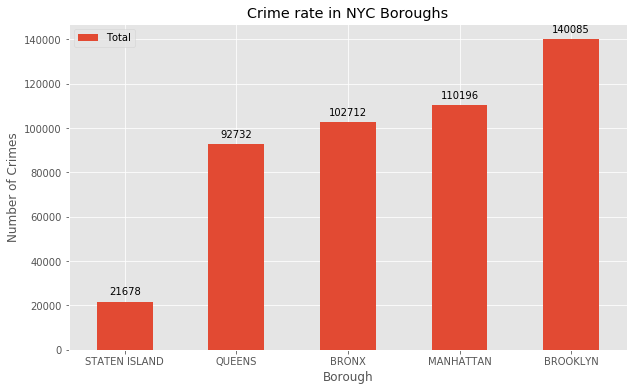

In [70]:
df_nyc_5 = df_5low[['Borough','Total']]

df_nyc_5.set_index('Borough',inplace = True)

ax = df_nyc_5.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') 
ax.set_xlabel('Borough')
ax.set_title('Crime rate in NYC Boroughs') 

# Percentage Function
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 10
               )

plt.show()

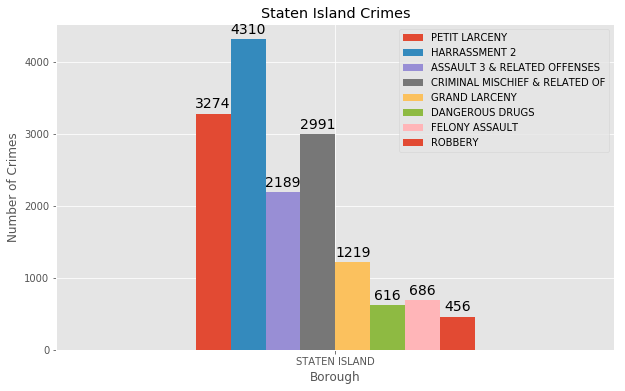

In [75]:
# Types of crimes in the borough 'STATEN ISLAND' - MOST SECURE BOROUGH
df_statisland1 =  df_5low[df_5low['Borough'] == 'STATEN ISLAND']

# Considering just some of the crimes
df_statisland = df_statisland1[['Borough','PETIT LARCENY','HARRASSMENT 2','ASSAULT 3 & RELATED OFFENSES','CRIMINAL MISCHIEF & RELATED OF',
                 'GRAND LARCENY','DANGEROUS DRUGS','FELONY ASSAULT', 'ROBBERY']]

df_statisland.set_index('Borough',inplace = True)

ax = df_statisland.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough') 
ax.set_title('Staten Island Crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

## Part C - Coordinates of the Neighborhoods of the safest borough (Staten Island)

In [76]:
# 'Arden Heights', 'Brighton Heights', 'Meiers Corners', 'Sandy Ground', 'Stapleton Heights'
# 'Manor Heights'

# Neighborhood = ['Annadale', 'Arlington', 'Arrochar', 'Bay Terrace', 'Bloomfield', 'Bulls Head', 'Castleton Corners', 'Charleston', 'Chelsea', 'Clifton',
# 'Concord', 'Dongan Hills', 'Egbertville', 'Elm Park', 'Eltingville', 'Emerson Hill', 'Fort Wadsworth', 'Graniteville', 'Grant City',' Grasmere', 'Great Kills', 'Greenridge', 'Grymes Hill',
# 'Hamilton Park', 'Heartland Village', 'Huguenot', 'Lighthouse Hill', 'Livingston', 'Manor Heights', 'Mariners Harbor', 'Midland Beach', 'New Brighton', 'New Dorp',
# 'New Springville', 'Oakwood', 'Old Place', 'Old Town', 'Pleasant Plains', 'Port Ivory', 'Port Richmond', 'Prince´s Bay', 'Randall Manor', 'Richmond Valley', 'Richmondtown', 'Rosebank',
# 'Rossville', 'Saint George', 'Shore Acres', 'Silver Lake', 'South Beach', 'Stapleton', 'Sunnyside', 'Todt Hill', 'Tompkinsville', 'Tottenville', 
# 'Tottenville Beach', 'Travis', 'Ward Hill', 'West New Brighton', 'Westerleigh', 'Willowbrook', 'Woodrow']


# WARNING! It was not possible to use geolocator with all that neighborhood, so I pick up some ot them

Neighborhood = ['Annadale', 'Arlington', 'Arrochar', 'Bay Terrace', 'Bloomfield', 'Bulls Head', 'Castleton Corners', 'Charleston', 'Chelsea', 'Clifton',
'Concord', 'Dongan Hills', 'Egbertville', 'Elm Park', 'Eltingville', 'Emerson Hill', 'Fort Wadsworth', 'Graniteville', 'Grant City',' Grasmere', 'Great Kills', 'Greenridge', 'Grymes Hill',
'Hamilton Park', 'Heartland Village','Huguenot', 'New Springville']

Borough = ['STATEN ISLAND', 'STATEN ISLAND', 'STATEN ISLAND', 'STATEN ISLAND', 'STATEN ISLAND', 'STATEN ISLAND', 'STATEN ISLAND', 'STATEN ISLAND', 'STATEN ISLAND',
          'STATEN ISLAND', 'STATEN ISLAND', 'STATEN ISLAND', 'STATEN ISLAND', 'STATEN ISLAND', 'STATEN ISLAND', 'STATEN ISLAND', 'STATEN ISLAND','STATEN ISLAND',
          'STATEN ISLAND', 'STATEN ISLAND', 'STATEN ISLAND', 'STATEN ISLAND','STATEN ISLAND', 'STATEN ISLAND', 'STATEN ISLAND', 'STATEN ISLAND', 'STATEN ISLAND']

Latitude = ['','','','','','','','','','','','','','','', '', '', '', '', '', '', '', '', '', '', '', '']
Longitude = ['','','','','','','','','','','','','','','', '', '', '', '', '', '', '', '', '', '', '', '']

df_neigh_statisl = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
statisl_neig = pd.DataFrame(data=df_neigh_statisl , columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

statisl_neig

,Neighborhood,Borough,Latitude,Longitude
0,Annadale,STATEN ISLAND,,
1,Arlington,STATEN ISLAND,,
2,Arrochar,STATEN ISLAND,,
3,Bay Terrace,STATEN ISLAND,,
4,Bloomfield,STATEN ISLAND,,
5,Bulls Head,STATEN ISLAND,,
6,Castleton Corners,STATEN ISLAND,,
7,Charleston,STATEN ISLAND,,
8,Chelsea,STATEN ISLAND,,
9,Clifton,STATEN ISLAND,,


In [77]:
# coordiantes of each Neighborhood in Staten Island Neighborhood
Latitude = []
Longitude = []

for i in range(len(Neighborhood)):
    address = '{}, New York, USA'.format(Neighborhood[i])
    geolocator = Nominatim(user_agent='New_York_City')
    location = geolocator.geocode(address)
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
print(Latitude, Longitude)

[40.5445496, 41.694069, 40.5984379, 40.5552778, 42.8950641, 40.6070484, 40.6131597, 40.5367719, 40.7464906, 40.6201041, 42.5353392, 40.5979271, 40.578622249999995, 40.6314925, 40.5453831, 40.6085851, 40.6089933, 40.6248259, 40.5820492, 40.6042711, 40.5542718, 40.5612236, 40.6187152, 40.6417264, 40.5883333, 40.5373275, 40.5934376] [-74.1765324, -73.88636347613317, -74.0726412, -74.1341667, -77.4347128, -74.1620879, -74.1223647, -74.2373672, -74.0015283, -74.0770857, -78.7308615, -74.0980274, -74.13156968455695, -74.1487544, -74.1656988, -74.0945642, -74.0626409, -74.1484765, -74.1048641, -74.087086, -74.1515318, -74.1698852, -74.0934751, -74.0900718, -74.1577778, -74.1945884, -74.163199]


In [175]:
# geolocator=Nominatim(timeout=3)

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  """Entry point for launching an IPython kernel.


In [78]:
df_neigh_statisl = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
statisl_neig = pd.DataFrame(data=df_neigh_statisl, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)
statisl_neig

,Neighborhood,Borough,Latitude,Longitude
0,Annadale,STATEN ISLAND,40.544550,-74.176532
1,Arlington,STATEN ISLAND,41.694069,-73.886363
2,Arrochar,STATEN ISLAND,40.598438,-74.072641
3,Bay Terrace,STATEN ISLAND,40.555278,-74.134167
4,Bloomfield,STATEN ISLAND,42.895064,-77.434713
5,Bulls Head,STATEN ISLAND,40.607048,-74.162088
6,Castleton Corners,STATEN ISLAND,40.613160,-74.122365
7,Charleston,STATEN ISLAND,40.536772,-74.237367
8,Chelsea,STATEN ISLAND,40.746491,-74.001528
9,Clifton,STATEN ISLAND,40.620104,-74.077086


In [79]:
# Get the coordinates of New Springville, NYC, USA (The center neighborhood of Staten Island)
address = 'New Springville, New York City, United States'
geolocator = Nominatim(user_agent="ld_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The coordinates of New Springville, New York are {}, {}.'.format(latitude, longitude))

The coordinates of New Springville, New York are 40.5934376, -74.163199.


In [80]:
# Visualize the Neighborhood of Staten Island and create map of New York using latitude and longitude values
nyc_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(statisl_neig['Latitude'], statisl_neig['Longitude'], statisl_neig['Borough'], statisl_neig['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(nyc_map)  
    
nyc_map 

In this part it will be find the venues 500m away from each neighborhood. Next, after perform one hot encoding, the venues will be grouped and 5-means clustering will be performed

In [81]:
# Get the venues from each Neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [82]:
statisl_venues = getNearbyVenues(names=statisl_neig['Neighborhood'],
                                   latitudes=statisl_neig['Latitude'],
                                   longitudes=statisl_neig['Longitude']
                                  )

Annadale
Arlington
Arrochar
Bay Terrace
Bloomfield
Bulls Head
Castleton Corners
Charleston
Chelsea
Clifton
Concord
Dongan Hills
Egbertville
Elm Park
Eltingville
Emerson Hill
Fort Wadsworth
Graniteville
Grant City
 Grasmere
Great Kills
Greenridge
Grymes Hill
Hamilton Park
Heartland Village
Huguenot
New Springville


In [88]:
print(statisl_venues.shape)
statisl_venues.head()

(365, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Annadale,40.54455,-74.176532,Annadale Terrace,40.542555,-74.177187,Restaurant
1,Annadale,40.54455,-74.176532,Annadale Diner,40.542079,-74.177325,Diner
2,Annadale,40.54455,-74.176532,Play Sports Bar,40.540418,-74.177196,Sports Bar
3,Annadale,40.54455,-74.176532,Il Sogno,40.541286,-74.178489,Restaurant
4,Annadale,40.54455,-74.176532,Harbor View Restoration LLC,40.544934,-74.174709,Construction & Landscaping


In [84]:
statisl_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Grasmere,13,13,13,13,13,13
Annadale,23,23,23,23,23,23
Arlington,8,8,8,8,8,8
Arrochar,7,7,7,7,7,7
Bay Terrace,7,7,7,7,7,7
Bloomfield,4,4,4,4,4,4
Bulls Head,21,21,21,21,21,21
Castleton Corners,29,29,29,29,29,29
Charleston,12,12,12,12,12,12


In [85]:
# How many unique categories are
print('There are {} uniques categories.'.format(len(statisl_venues['Venue Category'].unique())))

There are 115 uniques categories.


In [86]:
# One Hot Encoding
statisl_onehot = pd.get_dummies(statisl_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column 
statisl_onehot['Neighborhood'] = statisl_venues['Neighborhood'] 

# eighborhood column in the first column
fixed_columns = [statisl_onehot.columns[-1]] + list(statisl_onehot.columns[:-1])
statisl_onehot = statisl_onehot[fixed_columns]

statisl_onehot.head()

,Neighborhood,Acupuncturist,American Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Garden,Boat or Ferry,Bowling Alley,Breakfast Spot,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,College Theater,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Discount Store,Doctor's Office,Donut Shop,Elementary School,Event Space,Fast Food Restaurant,Flower Shop,Food,Food Truck,French Restaurant,Furniture / Home Store,Garden Center,Gastropub,General Entertainment,German Restaurant,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Ice Cream Shop,Indian Restaurant,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Lake,Lawyer,Liquor Store,Locksmith,Martial Arts Dojo,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Music Venue,Optical Shop,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Professional & Other Places,Pub,Ramen Restaurant,Rental Car Location,Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Shipping Store,Shopping Mall,Smoothie Shop,Soup Place,Spa,Spanish Restaurant,Sports Bar,Supermarket,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Theater,Thrift / Vintage Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Annadale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Annadale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Annadale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Annadale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Annadale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
# Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category
statisl_grouped = statisl_onehot.groupby('Neighborhood').mean().reset_index()
statisl_grouped

,Neighborhood,Acupuncturist,American Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,...,Theater,Thrift / Vintage Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Grasmere,0.076923,0.000000,0.000000,0.000000,0.000,0.000000,0.0,0.076923,0.000000,...,0.000000,0.000000,0.000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Annadale,0.000000,0.130435,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.043478,...,0.000000,0.000000,0.000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Arlington,0.000000,0.000000,0.000000,0.000000,0.000,0.250000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.125,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000
3,Arrochar,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.0,0.142857,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Bay Terrace,0.000000,0.142857,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Bloomfield,0.000000,0.250000,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Bulls Head,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Castleton Corners,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.0,0.034483,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Charleston,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.083333,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Chelsea,0.000000,0.033333,0.033333,0.000000,0.000,0.000000,0.0,0.033333,0.033333,...,0.033333,0.000000,0.000,0.000000,0.033333,0.000000,0.033333,0.033333,0.000000,0.000000


In [68]:
statisl_grouped.shape

(26, 116)

In [69]:
num_5topvenues = 5

for hood in statisl_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = statisl_grouped[statisl_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_5topvenues ))
    print('\n')

---- Grasmere----
                  venue  freq
0         Acupuncturist  0.08
1           Supermarket  0.08
2  Gym / Fitness Center  0.08
3                  Park  0.08
4   Peruvian Restaurant  0.08


----Annadale----
                 venue  freq
0          Pizza Place  0.13
1  American Restaurant  0.13
2           Restaurant  0.09
3             Bus Stop  0.04
4                 Food  0.04


----Arlington----
               venue  freq
0    Automotive Shop  0.25
1  Mobile Phone Shop  0.12
2        Event Space  0.12
3        Wings Joint  0.12
4  Convenience Store  0.12


----Arrochar----
           venue  freq
0    Pizza Place  0.29
1           Park  0.29
2  Deli / Bodega  0.14
3     Bagel Shop  0.14
4       Bus Stop  0.14


----Bay Terrace----
                 venue  freq
0  American Restaurant  0.14
1           Food Truck  0.14
2           Playground  0.14
3   Italian Restaurant  0.14
4        Train Station  0.14


----Bloomfield----
                 venue  freq
0       Ice Cream Shop  

In [70]:
# Dataframe of the venues
# Sort the venues in descending order.
def return_common_venues(row, num_5topvenues ):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_5topvenues]

In [71]:
# New dataframe with the top 5 venues for each neighborhood
num_5topvenues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_5topvenues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = statisl_grouped['Neighborhood']

for ind in np.arange(statisl_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_common_venues(statisl_grouped.iloc[ind, :], num_5topvenues )

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Grasmere,Acupuncturist,Supermarket,Gym / Fitness Center,Intersection,Italian Restaurant
1,Annadale,American Restaurant,Pizza Place,Restaurant,Liquor Store,Sports Bar
2,Arlington,Automotive Shop,Convenience Store,Event Space,Mobile Phone Shop,Trail
3,Arrochar,Pizza Place,Park,Deli / Bodega,Bagel Shop,Bus Stop
4,Bay Terrace,Italian Restaurant,American Restaurant,Miscellaneous Shop,Playground,Food Truck


In [72]:
# 5 - means clustering to cluster similar neighborhoods together 

from sklearn.cluster import KMeans

# nr cluster
kclusters = 5

statisl_grouped_clustering = statisl_grouped.drop('Neighborhood', 1)

# 5-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(statisl_grouped_clustering)

kmeans.labels_[0:5]

array([0, 0, 0, 0, 0])

In [73]:
# clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

statisl_merged = statisl_neig

# merge and add latitude/longitude for each neighborhood
statisl_merged = statisl_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

statisl_merged.head() 

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Annadale,STATEN ISLAND,40.544550,-74.176532,0.0,American Restaurant,Pizza Place,Restaurant,Liquor Store,Sports Bar
1,Arlington,STATEN ISLAND,41.694069,-73.886363,0.0,Automotive Shop,Convenience Store,Event Space,Mobile Phone Shop,Trail
2,Arrochar,STATEN ISLAND,40.598438,-74.072641,0.0,Pizza Place,Park,Deli / Bodega,Bagel Shop,Bus Stop
3,Bay Terrace,STATEN ISLAND,40.555278,-74.134167,0.0,Italian Restaurant,American Restaurant,Miscellaneous Shop,Playground,Food Truck
4,Bloomfield,STATEN ISLAND,42.895064,-77.434713,0.0,Ice Cream Shop,American Restaurant,Pizza Place,Lawyer,Flower Shop


In [74]:
statisl_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 10 columns):
Neighborhood             27 non-null object
Borough                  27 non-null object
Latitude                 27 non-null float64
Longitude                27 non-null float64
Cluster Labels           26 non-null float64
1st Most Common Venue    26 non-null object
2nd Most Common Venue    26 non-null object
3rd Most Common Venue    26 non-null object
4th Most Common Venue    26 non-null object
5th Most Common Venue    26 non-null object
dtypes: float64(3), object(7)
memory usage: 2.2+ KB


In [75]:
# Dropping NaN values
statisl_merged.dropna(inplace = True)

In [76]:
statisl_merged.shape

(26, 10)

In [77]:
statisl_merged['Cluster Labels'] = statisl_merged['Cluster Labels'].astype(int)

In [78]:
statisl_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 0 to 26
Data columns (total 10 columns):
Neighborhood             26 non-null object
Borough                  26 non-null object
Latitude                 26 non-null float64
Longitude                26 non-null float64
Cluster Labels           26 non-null int32
1st Most Common Venue    26 non-null object
2nd Most Common Venue    26 non-null object
3rd Most Common Venue    26 non-null object
4th Most Common Venue    26 non-null object
5th Most Common Venue    26 non-null object
dtypes: float64(2), int32(1), object(7)
memory usage: 2.1+ KB


In [79]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# color scheme 
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers 
markers_colors = []
for lat, lon, poi, cluster in zip(statisl_merged['Latitude'], statisl_merged['Longitude'], statisl_merged['Neighborhood'], statisl_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

## Analysis

In [81]:
# First cluster
statisl_merged[statisl_merged['Cluster Labels'] == 0]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Annadale,STATEN ISLAND,40.544550,-74.176532,0,American Restaurant,Pizza Place,Restaurant,Liquor Store,Sports Bar
1,Arlington,STATEN ISLAND,41.694069,-73.886363,0,Automotive Shop,Convenience Store,Event Space,Mobile Phone Shop,Trail
2,Arrochar,STATEN ISLAND,40.598438,-74.072641,0,Pizza Place,Park,Deli / Bodega,Bagel Shop,Bus Stop
3,Bay Terrace,STATEN ISLAND,40.555278,-74.134167,0,Italian Restaurant,American Restaurant,Miscellaneous Shop,Playground,Food Truck
4,Bloomfield,STATEN ISLAND,42.895064,-77.434713,0,Ice Cream Shop,American Restaurant,Pizza Place,Lawyer,Flower Shop
5,Bulls Head,STATEN ISLAND,40.607048,-74.162088,0,Bus Stop,Pharmacy,Diner,Baseball Field,Tattoo Parlor
6,Castleton Corners,STATEN ISLAND,40.613160,-74.122365,0,Pizza Place,Bank,Ice Cream Shop,Convenience Store,Salon / Barbershop
7,Charleston,STATEN ISLAND,40.536772,-74.237367,0,Construction & Landscaping,Bakery,Gym / Fitness Center,Deli / Bodega,Rental Car Location
8,Chelsea,STATEN ISLAND,40.746491,-74.001528,0,Café,French Restaurant,Sushi Restaurant,Coffee Shop,Indian Restaurant
12,Egbertville,STATEN ISLAND,40.578622,-74.131570,0,Construction & Landscaping,Italian Restaurant,Bagel Shop,Trail,Cosmetics Shop


In [82]:
# Second
statisl_merged[statisl_merged['Cluster Labels'] == 1]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
25,Huguenot,STATEN ISLAND,40.537328,-74.194588,1,Train Station,Italian Restaurant,Movie Theater,Yoga Studio,Flower Shop


In [83]:
# Third
statisl_merged[statisl_merged['Cluster Labels'] == 2]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
22,Grymes Hill,STATEN ISLAND,40.618715,-74.093475,2,Indie Theater,Golf Course,Trail,Café,Yoga Studio


In [84]:
# Fourth
statisl_merged[statisl_merged['Cluster Labels'] == 3]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
9,Clifton,STATEN ISLAND,40.620104,-74.077086,3,Bus Stop,Grocery Store,Intersection,Deli / Bodega,Train Station
13,Elm Park,STATEN ISLAND,40.631493,-74.148754,3,Deli / Bodega,Italian Restaurant,Bus Stop,Athletics & Sports,Furniture / Home Store
15,Emerson Hill,STATEN ISLAND,40.608585,-74.094564,3,Bus Stop,Acupuncturist,Deli / Bodega,Intersection,Automotive Shop
23,Hamilton Park,STATEN ISLAND,40.641726,-74.090072,3,Bus Stop,Park,Bowling Alley,Mexican Restaurant,Deli / Bodega
24,Heartland Village,STATEN ISLAND,40.588333,-74.157778,3,Gym / Fitness Center,Sandwich Place,Bus Stop,Bus Station,Yoga Studio


In [85]:
# Fifth
statisl_merged[statisl_merged['Cluster Labels'] == 4]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
11,Dongan Hills,STATEN ISLAND,40.597927,-74.098027,4,Pizza Place,Asian Restaurant,Flower Shop,Yoga Studio,Food
